# Starbucks Capstone Challenge

## Introduction
The datasets contain simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). The project represents a one-month experiment for Starbucks to test out the market and see what offers really excite different demographics of people.

## Project Motivation
The purpose of this project is to determine which demographic groups respond best to which offer types, to help Starbucks make better decisions on sending out offers to targeted customers to increase sales and potentially save money.

By sending offers to the RIGHT customers:
- Starbucks can boost brand recognition, customer loyalty, increase sales activities, promote a new product, etc.

By NOT sending offers to the RIGHT customers:
- Starbucks can save costs on the promotion event on customers who would make purchases without offers
- Starbucks can prevent customers from reacting negatively to an offer by not sending the offer

In [61]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, r2_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-dark')

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**offers (portfolio.json)**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**customers (profile.json)**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**events (transcript.json)**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [62]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv')
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306514 rows


## Define Customer Response
**A user can receive an offer, never actually view the offer, and still complete the offer.**  
**As a result, we want to segment all customers into 3 groups:**
- **responded**
    - customers who were influenced by the offer and made a purchase - those who **RECEIVED, VIEWED, AND COMPLETED THE OFFER**
- **not_responded**
    - customers who were not influenced by the offer and didn't make a purchase - those who **RECEIVED, VIEWED, AND NOT COMPLETED THE OFFER**
- **invalid_responded**
    - customers who were not influenced by the offer but did make a purchase - those who **RECEIVED, NOT VIEWED, BUT COMPLETED THE OFFER**

### Exclude informational offers
- The objective of the project is to predict customer response to offers, informational offers do not lead to any response
- Exclude them to only analyze discount and bogo offers
- Seperate transaction events and offer events, to define customer response based on offer events

In [63]:
# Add offer info into events dataset
events = pd.merge(events, offers[['id','offer','offer_type']], how='left', left_on='offer_id', right_on='id').drop(['id','offer_id'],axis=1)
events.offer.unique()

array(['bogo_5_7_5', 'discount_20_10_5', 'discount_10_7_2',
       'discount_10_10_2', 'bogo_10_5_10', 'bogo_5_5_5', 'discount_7_7_3',
       'informational_0_4_0', 'bogo_10_7_10', 'informational_0_3_0', nan],
      dtype=object)

In [64]:
# Store offer types
informational_offers = ['informational_0_3_0','informational_0_4_0']
discount_offers = ['discount_20_10_5','discount_10_7_2','discount_10_10_2','discount_7_7_3']
bogo_offers = ['bogo_5_7_5','bogo_10_5_10','bogo_5_5_5','bogo_10_7_10']

# Remove informational events out of events data
informational_events = events[events.offer.isin(informational_offers)]
offer_events = events[~events.offer.isin(informational_offers)]

# Remove transaction events out of events data and store in offer_events
offer_events = offer_events[offer_events.event != 'transaction']
transaction_events = events[events.event == 'transaction']

### Create customer_funnels dataset to segment customer groups

In [65]:
# Create customer_funnels dataset
customer_funnels = offer_events.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
customer_funnels = pd.pivot(customer_funnels, index='customer_id', columns='event', values='count')
customer_funnels.columns = [col.replace(' ', '_') for col in customer_funnels.columns]
customer_funnels.sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
6d8a255c4ce64314afab49e51914c7c7,4.0,4.0,4.0
d54ad47d89284047809a1626127cad82,1.0,3.0,3.0
be15020b871e45ab8e2e1b9e6a8cec75,3.0,4.0,3.0
d824bb703d434f5fa99b99cb0a85635a,2.0,2.0,2.0
1359818aa5bc4becaad9c18df5dbf776,3.0,4.0,4.0


- 100% customers in this data received at least 1 offer
- 24.5% customers didn't complete the offer
- 2.4% customers didn't view the offer

In [66]:
customer_funnels.isnull().mean() * 100

offer_completed    24.539225
offer_received      0.000000
offer_viewed        2.392486
dtype: float64

In [67]:
def create_3_demo_groups(funnel):
    '''
    create 3 datasets that describe customer funnels for 3 response types - responded/not_responded/invalid_responded

    INPUT:
        funnel - a customer funnel dataset for all offer events, OR for a specific offer type (discount, BOGO)
    OUTPUT:
        responded, not_responded, invalid_responded - segmented datasets from the original funnel data
    '''

    # Create 3 response type groups
    responded = funnel.dropna()
    not_responded = funnel[funnel.offer_completed.isnull()]
    invalid_responded = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()]

    print(round(len(responded)/len(funnel)*100,2), '% customers responded to offers')
    print(round(len(not_responded)/len(funnel)*100,2), '% customers did not respond to any offer')
    print(round(len(invalid_responded)/len(funnel)*100,2), '% customers completed offers without viewing offer')

    # Make sure these 3 demographic groups are broken down correctly
    assert len(responded) + len(not_responded) + len(invalid_responded) == len(funnel), '3 demographic groups not broken down correctly'  

    return responded, not_responded, invalid_responded

### customer_funnels dataset represents customer response for all offers
So we know that for all offers:
- 74.4 % customers responded to at least 1 offer
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed all received offers without viewing them

**Later on, the funnel input will be funnels for a specific offer, to analyze each offer individually**

In [68]:
responded, not_responded, invalid_responded = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


In [69]:
# Impute responses into customers data
customers['responded'] = customers.id.isin(responded.index).astype(int)
customers['not_responded'] = customers.id.isin(not_responded.index).astype(int)
customers['invalid_responded'] = customers.id.isin(invalid_responded.index).astype(int)
customers['response'] = customers[['responded','not_responded','invalid_responded']].idxmax(axis=1)
customers.head()

,gender,age,id,income,membership_days,responded,not_responded,invalid_responded,response
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,1,0,0,responded
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,0,1,invalid_responded
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,0,1,0,not_responded
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,0,responded
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,0,1,0,not_responded


# Demographic EDA for the 3 response types

In [70]:
# Null values in customers data
customers.isnull().mean()

gender               0.127928
age                  0.127928
id                   0.000000
income               0.127928
membership_days      0.000000
responded            0.000000
not_responded        0.000000
invalid_responded    0.000000
response             0.000000
dtype: float64

In [71]:
# Some customers didn't provide any information regarding age, gender and income
# Remove them from customers dataset and create null_customers to store them
null_customers = customers[customers.isnull().any(axis=1)]
customers = customers.dropna()
print(f'response rate for null_customers: {null_customers.responded.mean()}')
print('Looks like customers who do not provide demographic information has a low response rate')

response rate for null_customers: 0.36016559337626497
Looks like customers who do not provide demographic information has a low response rate


In [72]:
def plot_compare_3_groups(funnel):

    '''
    plot age/income/membership_days distributions by the 3 response groups

    INPUT:
        funnel - a customer funnel dataset for all offer events, OR for a specific offer type (discount, BOGO)
    OUTPUT:
        None - plot 3 distributions
    '''

    # Define response groups
    responded, not_responded, invalid_responded = create_3_demo_groups(funnel)

    # Plot 3 graphs
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    sns.distplot(customers[customers.id.isin(responded.index)].age, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].age, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].age, label='invalid responded');
    plt.legend();
    plt.subplot(1,3,2)
    sns.distplot(customers[customers.id.isin(responded.index)].income, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].income, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].income, label='invalid responded');
    plt.legend();
    plt.subplot(1,3,3)
    sns.distplot(customers[customers.id.isin(responded.index)].membership_days, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].membership_days, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].membership_days, label='invalid responded');
    plt.legend();
    plt.tight_layout()

### EDA insights for all offers in general
- In general, 74.4% customers responded to offers, and 1.06% customers invalidly responded to offers
- **not responded customers (orange bars)** are mostly young in age, have low income, and have a short length of membership
- **responded customers (blue bars)** are average in age, average in income, and average in length of membership
- **invalid responded customers (green bars)** are the highest in age, the highest in income, highest in length of membership
- The distributions of membership_days suggest that it is the biggest factor for customer response. It may be because new members don't know how to nevigate around the app and respond to the offers.

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


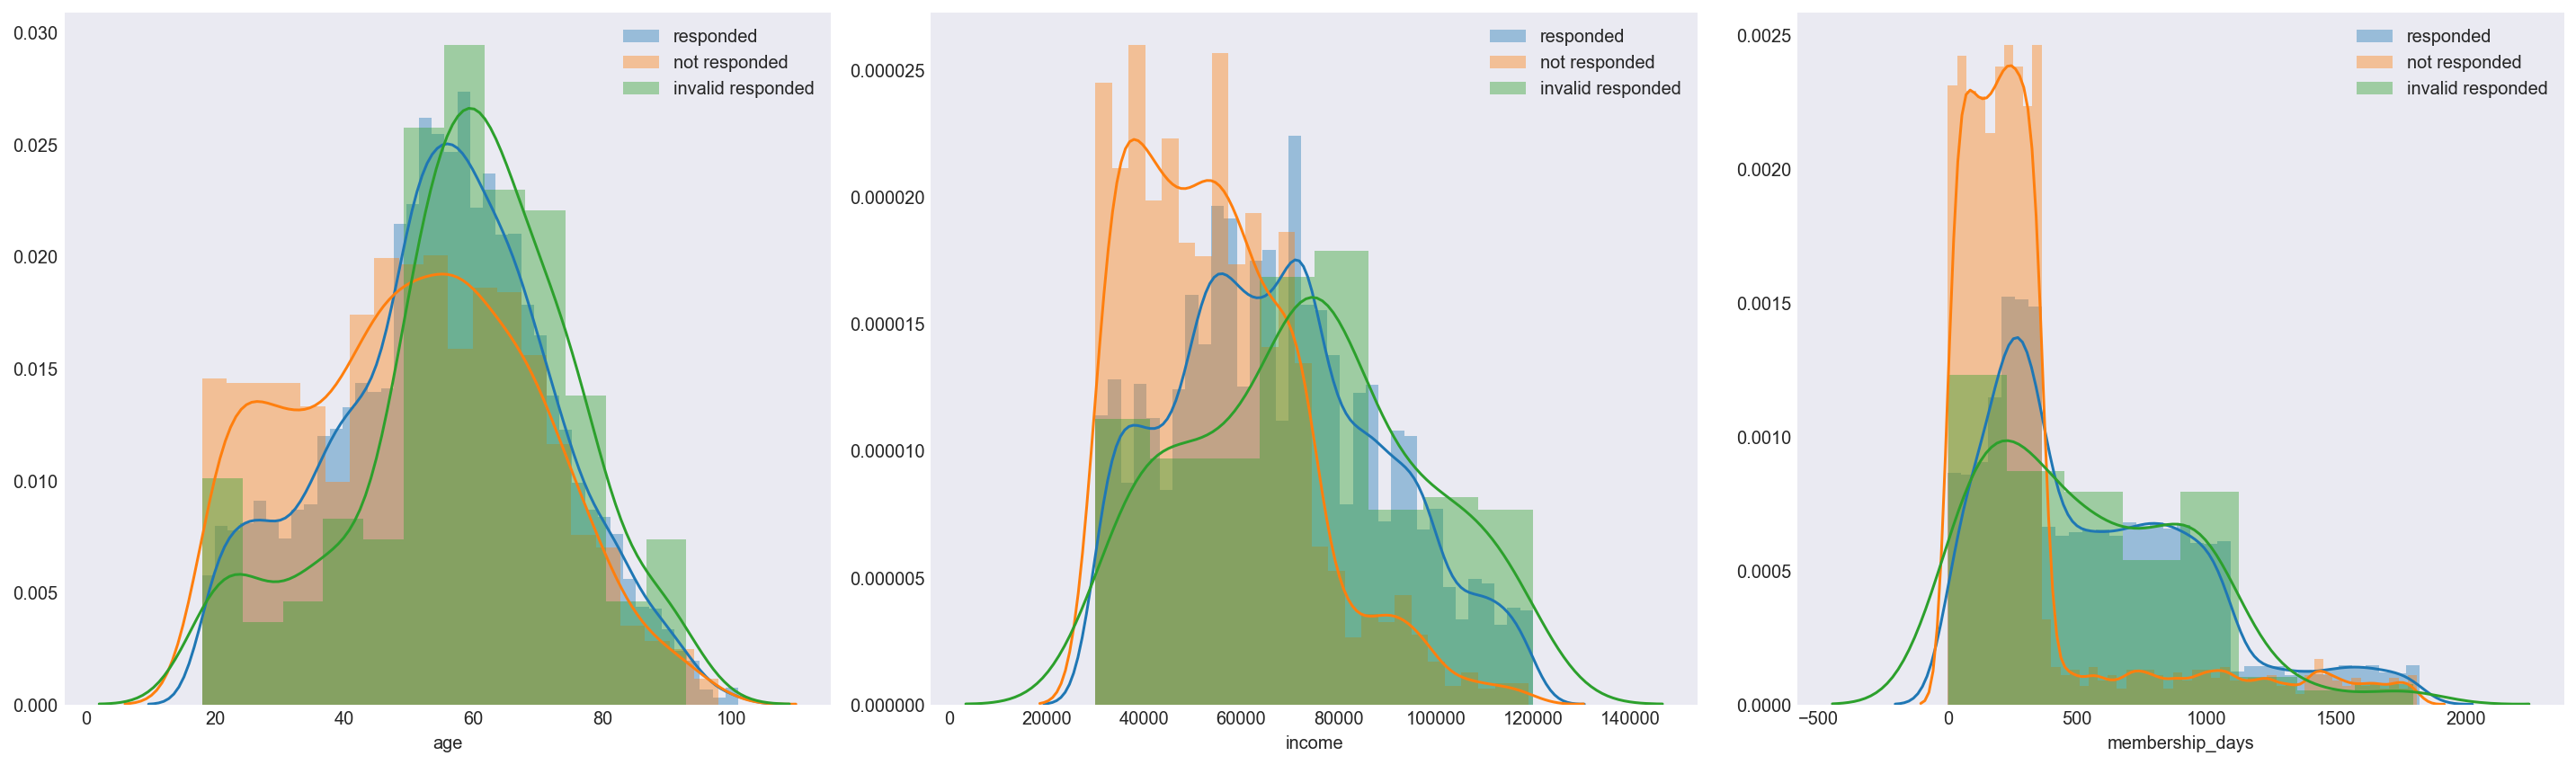

In [15]:
plot_compare_3_groups(customer_funnels)

# Dicount VS BOGO offers

In [73]:
def create_offer_type_funnels(offer_type):

    '''
    create a funnel dataset either offer types - discount offers and bogo offers

    INPUT:
        offer - the offer type
    OUTPUT:
        funnel - customer funnel dataset of this given offer
    '''

    # Create funnel
    funnel = offer_events[offer_events.offer_type == offer_type]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]

    return funnel

In [74]:
create_offer_type_funnels('discount').sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
20116a389d124791907f093f7d821ad4,NaN,1.0,1.0
7bd0d9a569a74eb3949955b4548f34db,NaN,1.0,NaN
92481d2ef5584daa9d4a17725a31792d,1.0,1.0,NaN
406e02eb805440949a9c37122c75d2f8,1.0,2.0,1.0
1f68e9b6850f49348235a281a47d9f15,2.0,2.0,2.0


- discount offers seems to have a slightly higher response rate than bogo offers (63% verses 59%)
- The demographics of discount and bogo response groups are quite similar

62.92 % customers responded to offers
31.15 % customers did not respond to any offer
5.92 % customers completed offers without viewing offer


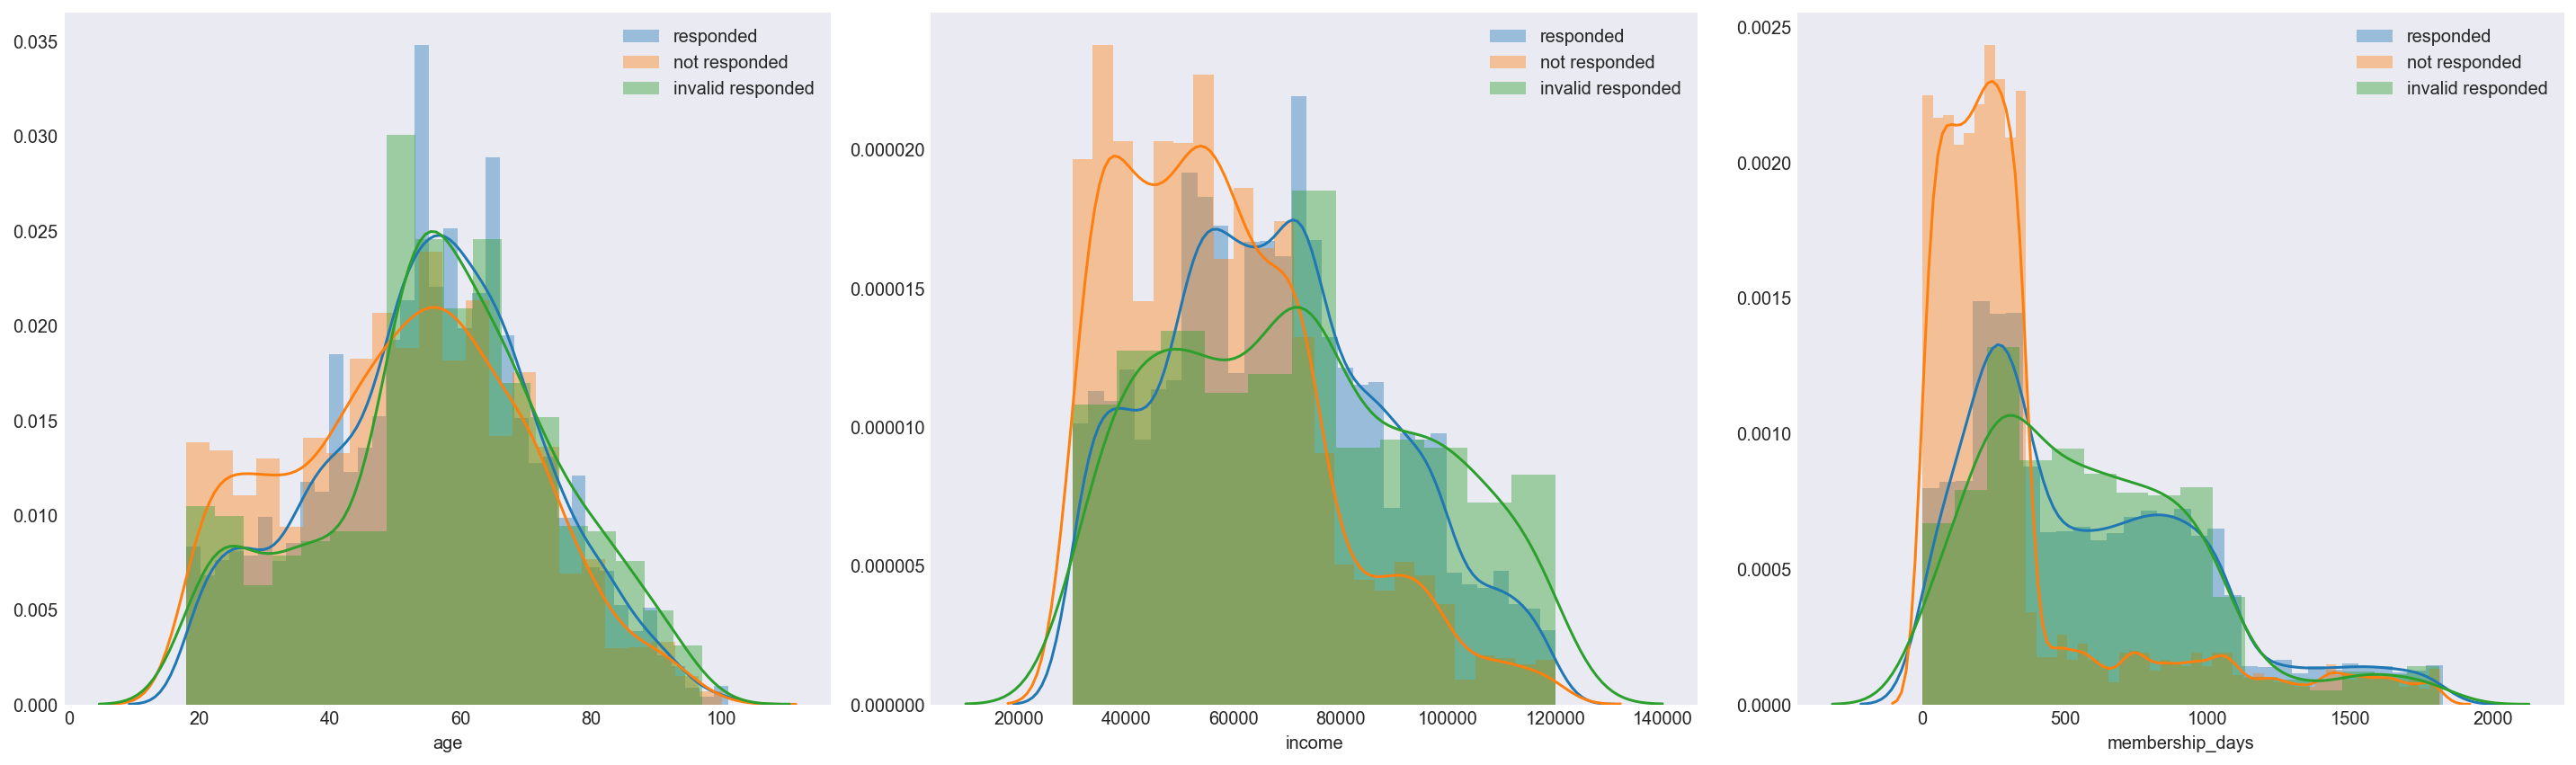

In [22]:
plot_compare_3_groups(create_offer_type_funnels('discount'))

58.72 % customers responded to offers
38.21 % customers did not respond to any offer
3.06 % customers completed offers without viewing offer


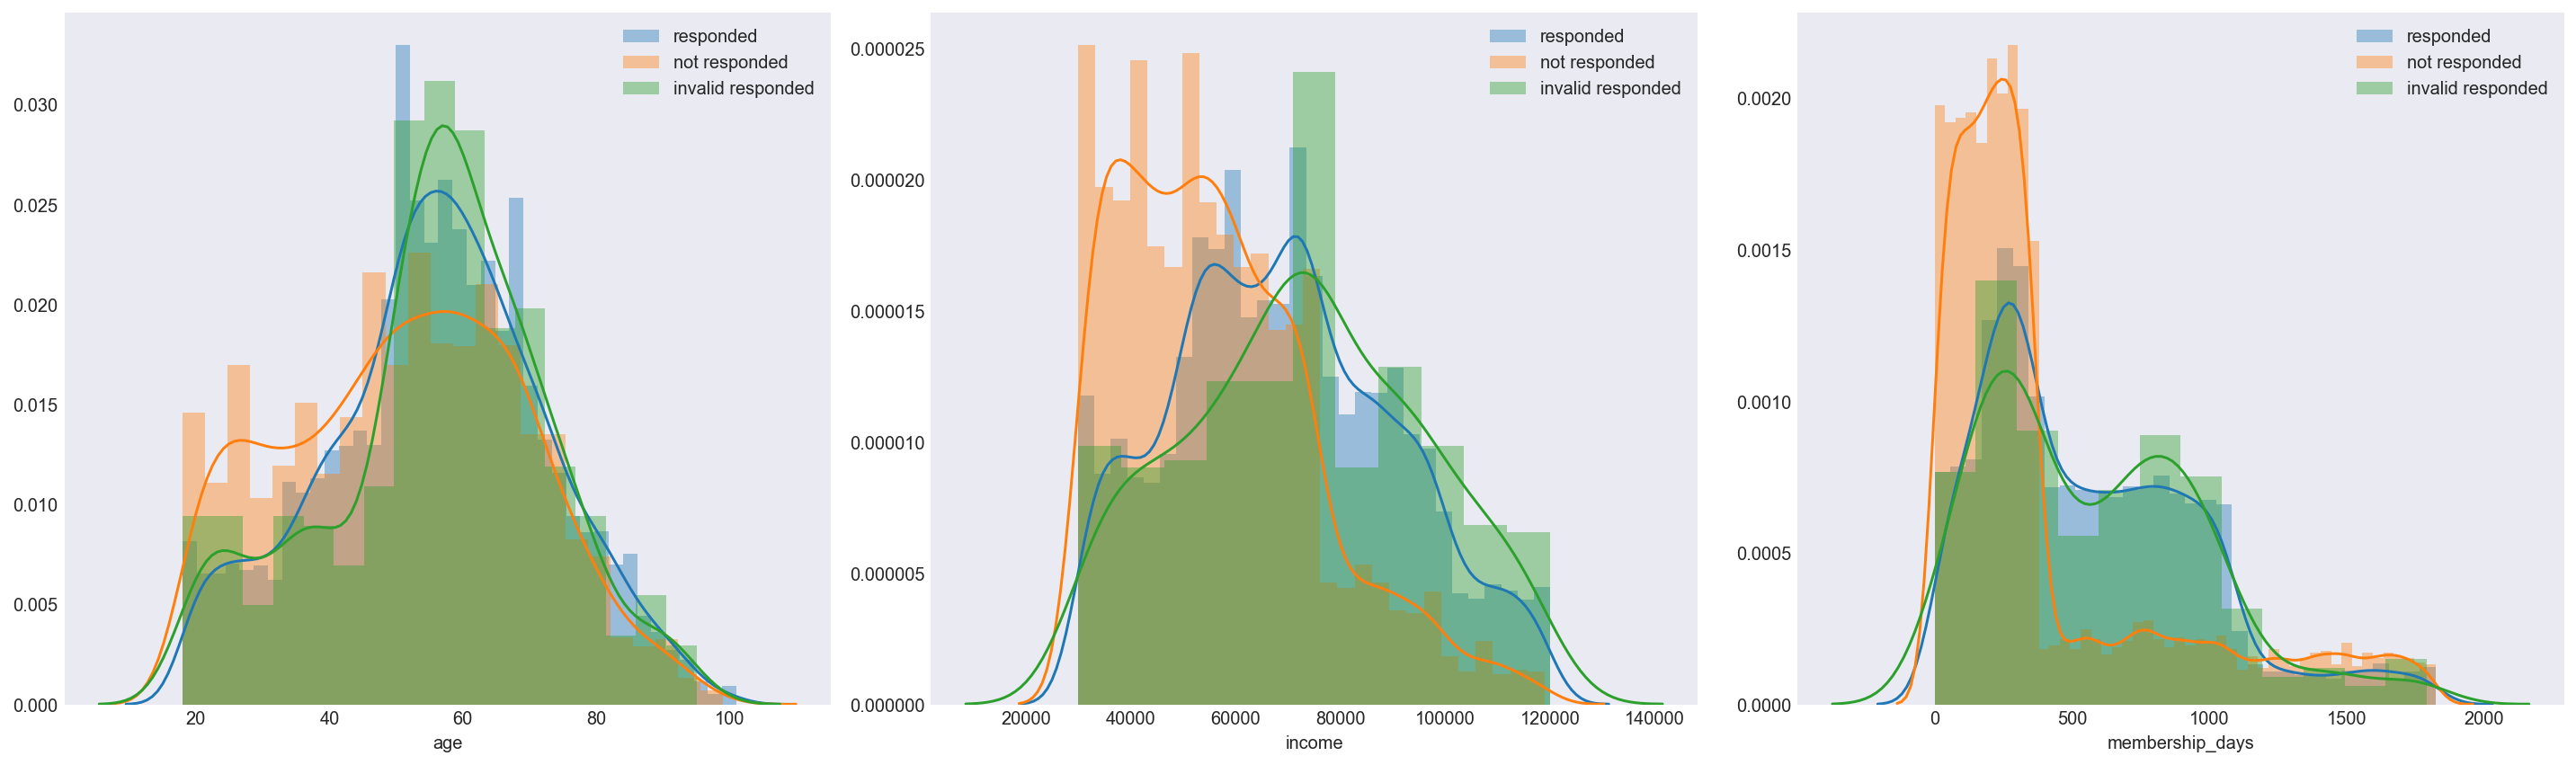

In [23]:
plot_compare_3_groups(create_offer_type_funnels('bogo'))

### Dig deeper into response groups by each offer type

In [75]:
def create_offer_funnels(offer):

    '''
    create a funnel dataset by 8 different offer types - discount offers and bogo offers

    INPUT:
        offer - the specific offer type (discount_7_7_3)
    OUTPUT:
        funnel - customer funnel dataset of this given offer
    '''

    # create funnel for the given offer
    funnel = offer_events[offer_events.offer == offer]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]

    return funnel

In [76]:
create_offer_funnels('discount_7_7_3').sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
2989ffb9c4d0431b8c7f21368b21f804,1.0,1.0,1.0
c7c7c87a97a04536b8c7f5a5e386935a,1.0,1.0,1.0
bf1b561379e04f6cb6c21901805c3c95,1.0,1.0,1.0
36ee9d2930c14d8c85f7a01a56001713,NaN,2.0,2.0
ea9fa7fbbcdc44d79b0f0d62d5bbbc41,1.0,1.0,1.0


### Demographic EDA for discount offers
- Note that the offers are broken down into **min_spend, expire_days, and reward**
- For example, discount_20_10_5 means a discount offer with 20 dollars minumum spend, expires in 10 days, and 5 dollars reward

### Insights:
- The discount offer people love the most is discount_10_10_2, with 70.1% response rate
- The discount offer people love the least is discount_20_10_5, with 23.09 response rate
- This may be due to the fact that the favorable offer has a lower barrier (10 dollars) whereas the least favorable offer has a high minimum spend (20 dollars)
- discount_10_7_2 has a 38% response rate whereas discount_10_10_2 has a 70.1% response rate, this may suggest that an 10-day expiration period gets much more responses than a 7-day expiration period
- **In conclusion, people respond better to lower minimum spend and longer expiration days**

In [77]:
# Exammine discount offer types
discount_offers

['discount_20_10_5', 'discount_10_7_2', 'discount_10_10_2', 'discount_7_7_3']

23.09 % customers responded to offers
53.28 % customers did not respond to any offer
23.63 % customers completed offers without viewing offer


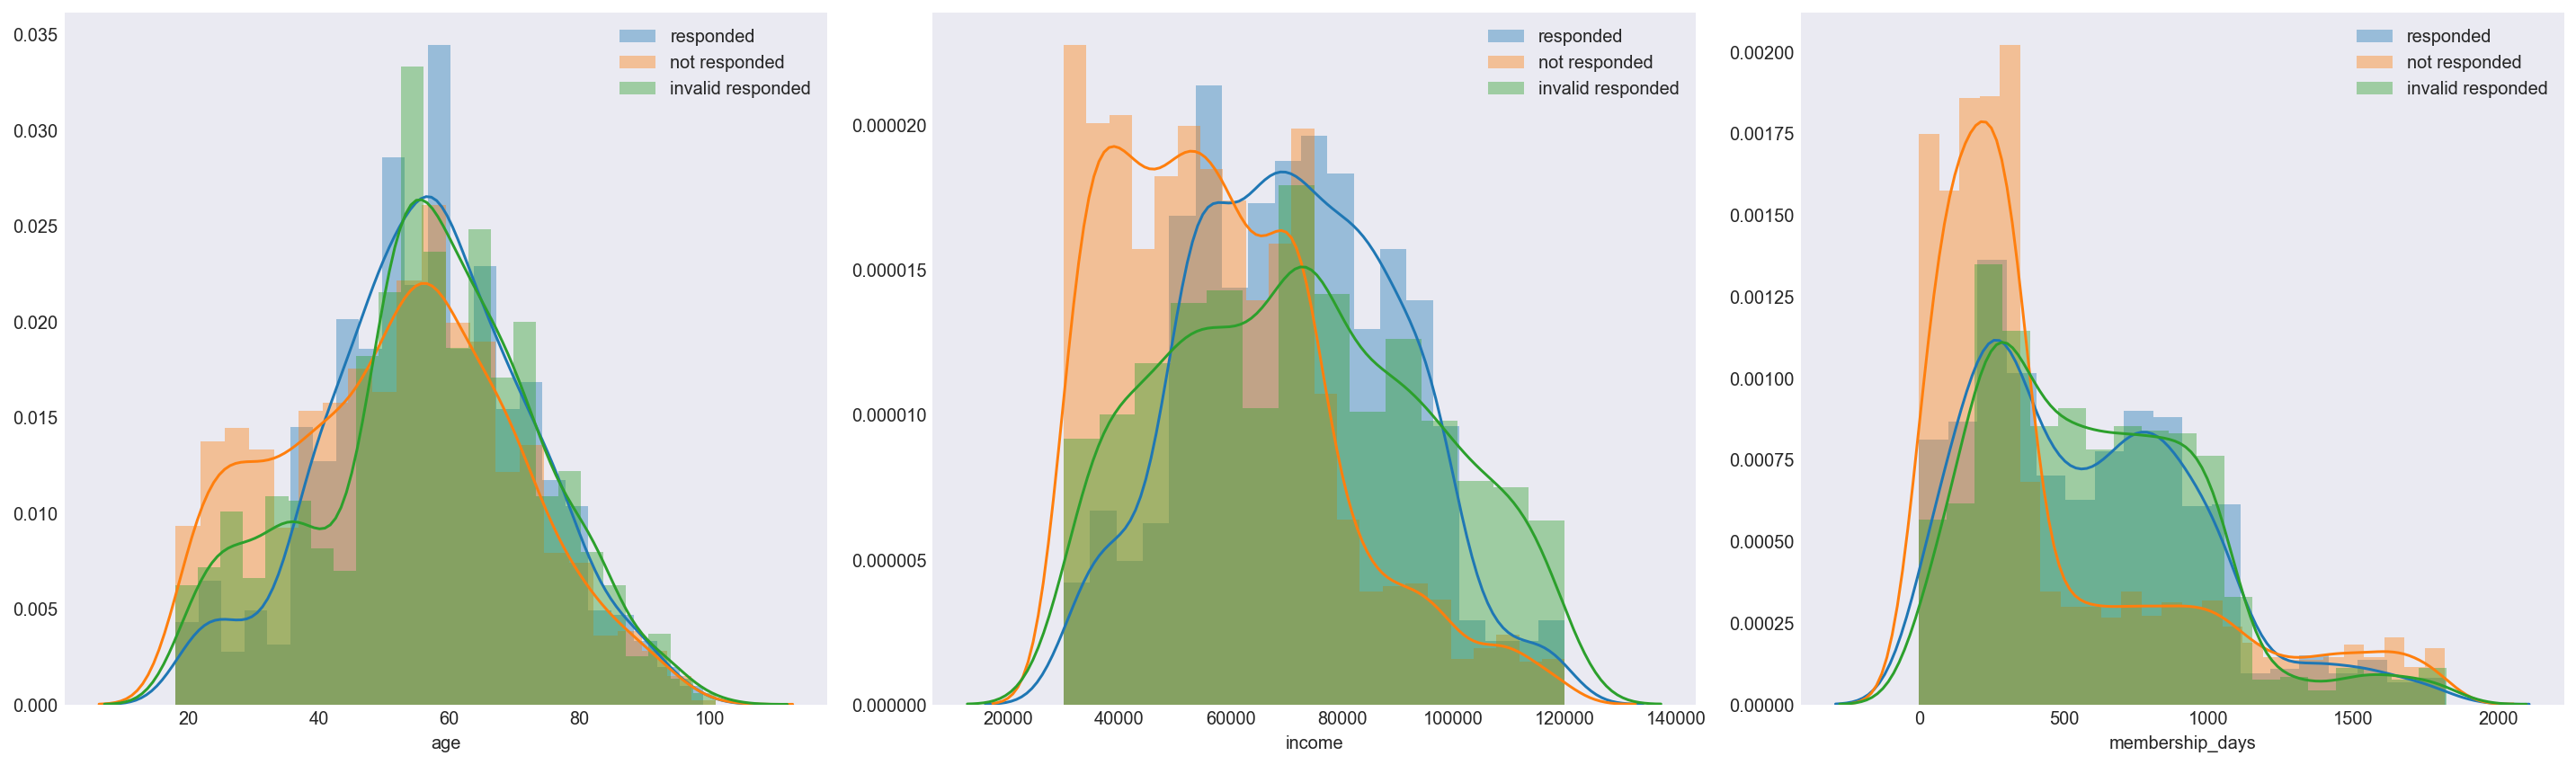

In [78]:
plot_compare_3_groups(create_offer_funnels('discount_20_10_5'))

38.42 % customers responded to offers
44.63 % customers did not respond to any offer
16.95 % customers completed offers without viewing offer


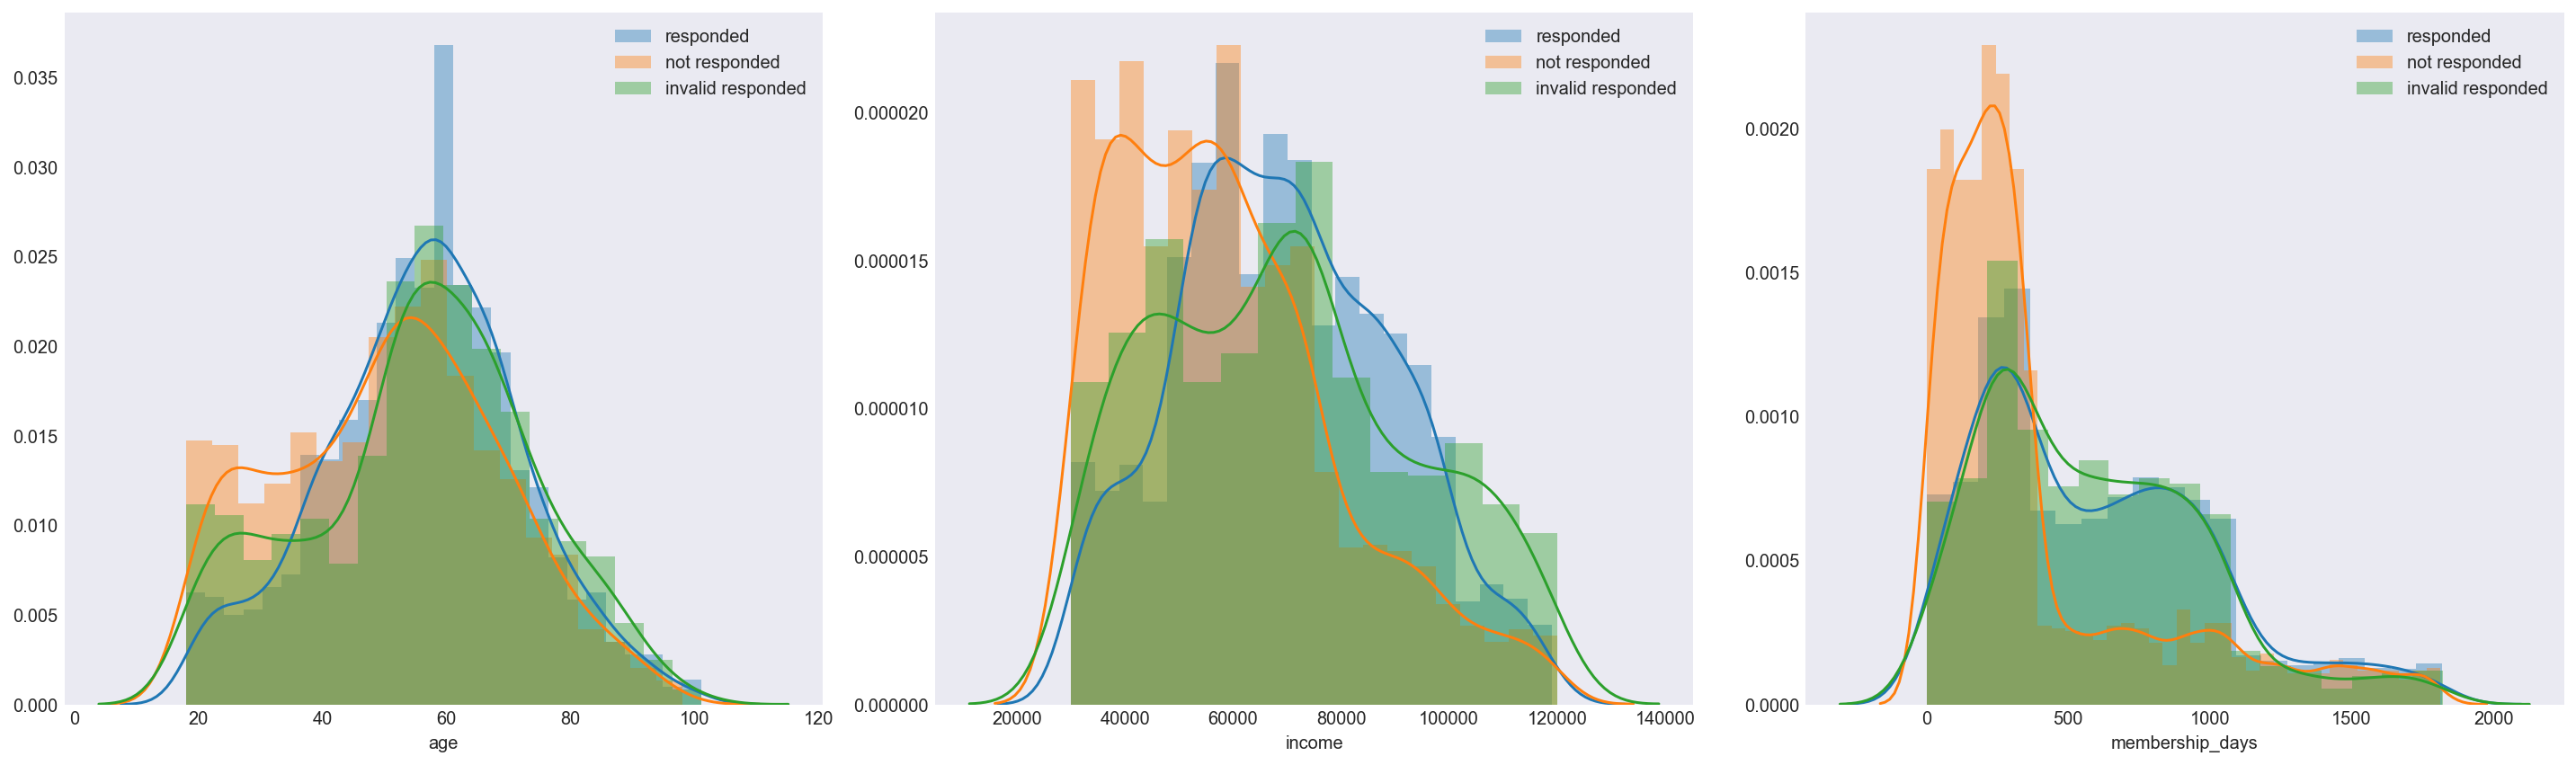

In [26]:
plot_compare_3_groups(create_offer_funnels('discount_10_7_2'))

70.01 % customers responded to offers
28.46 % customers did not respond to any offer
1.53 % customers completed offers without viewing offer


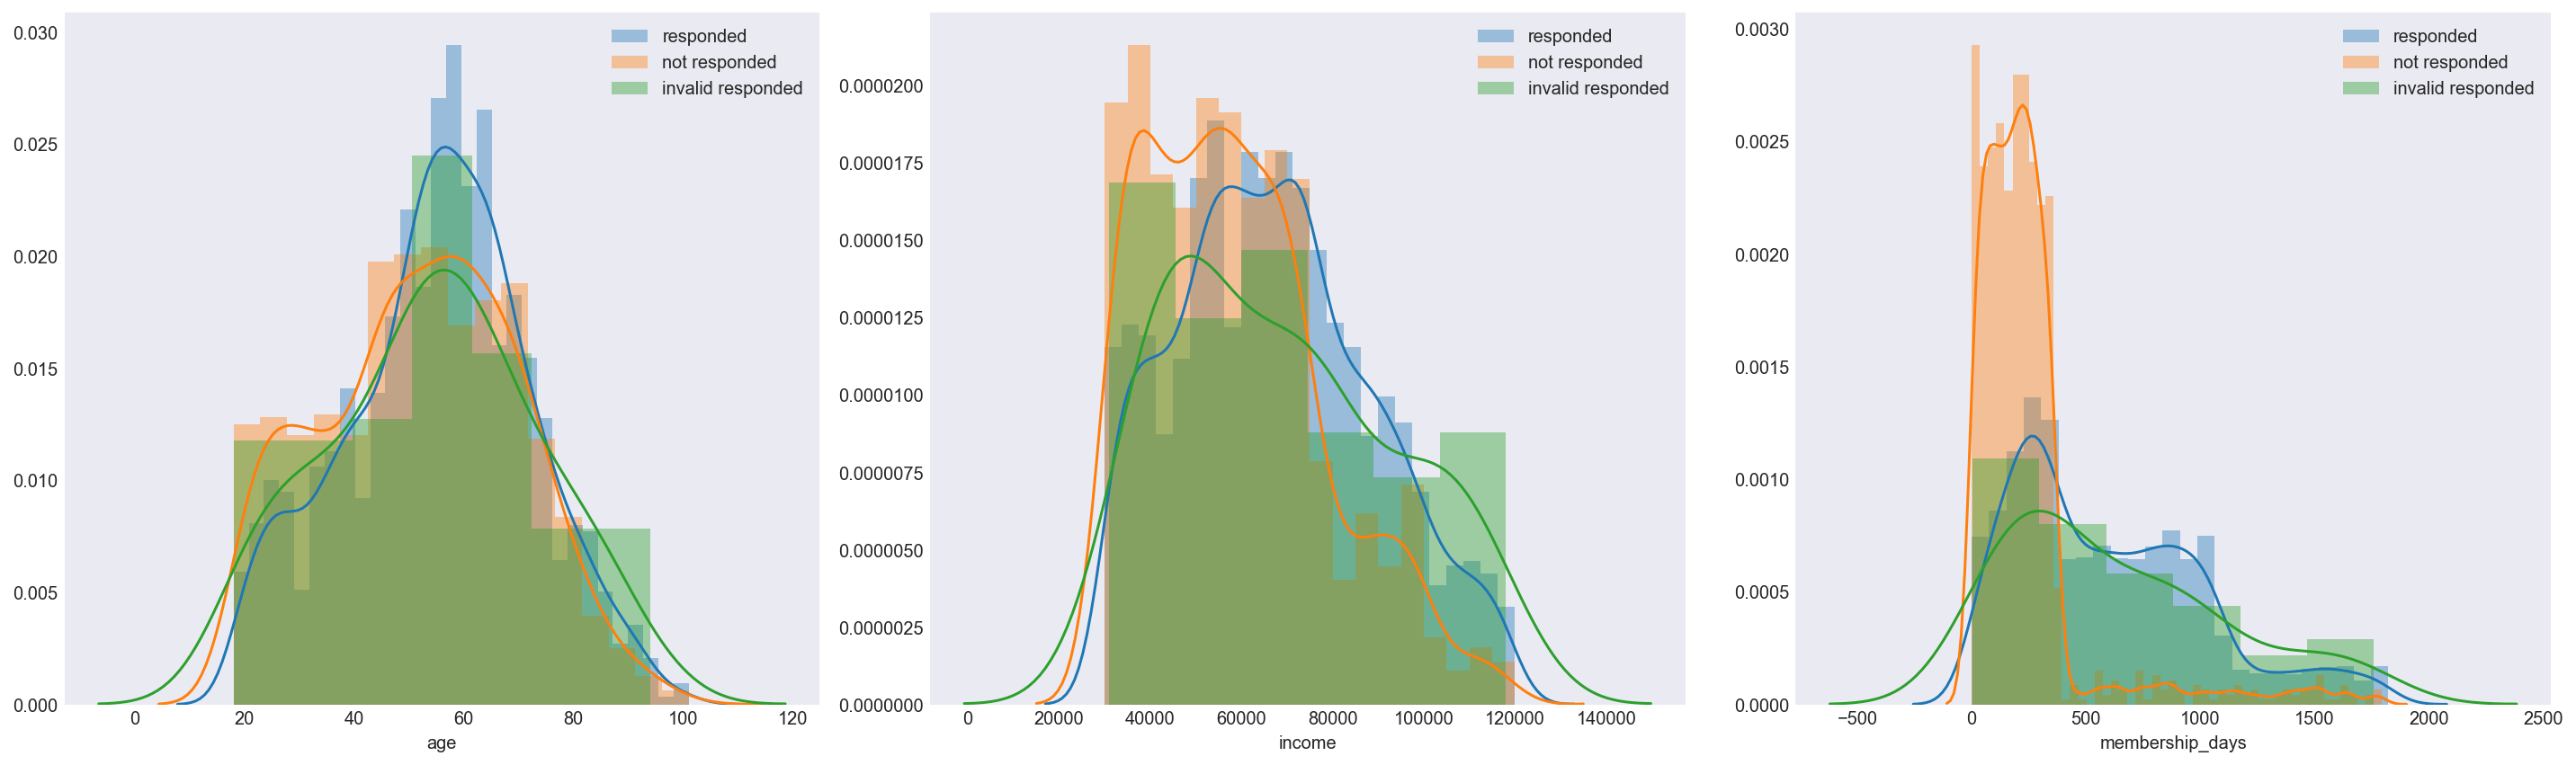

In [25]:
plot_compare_3_groups(create_offer_funnels('discount_10_10_2'))

68.19 % customers responded to offers
30.1 % customers did not respond to any offer
1.71 % customers completed offers without viewing offer


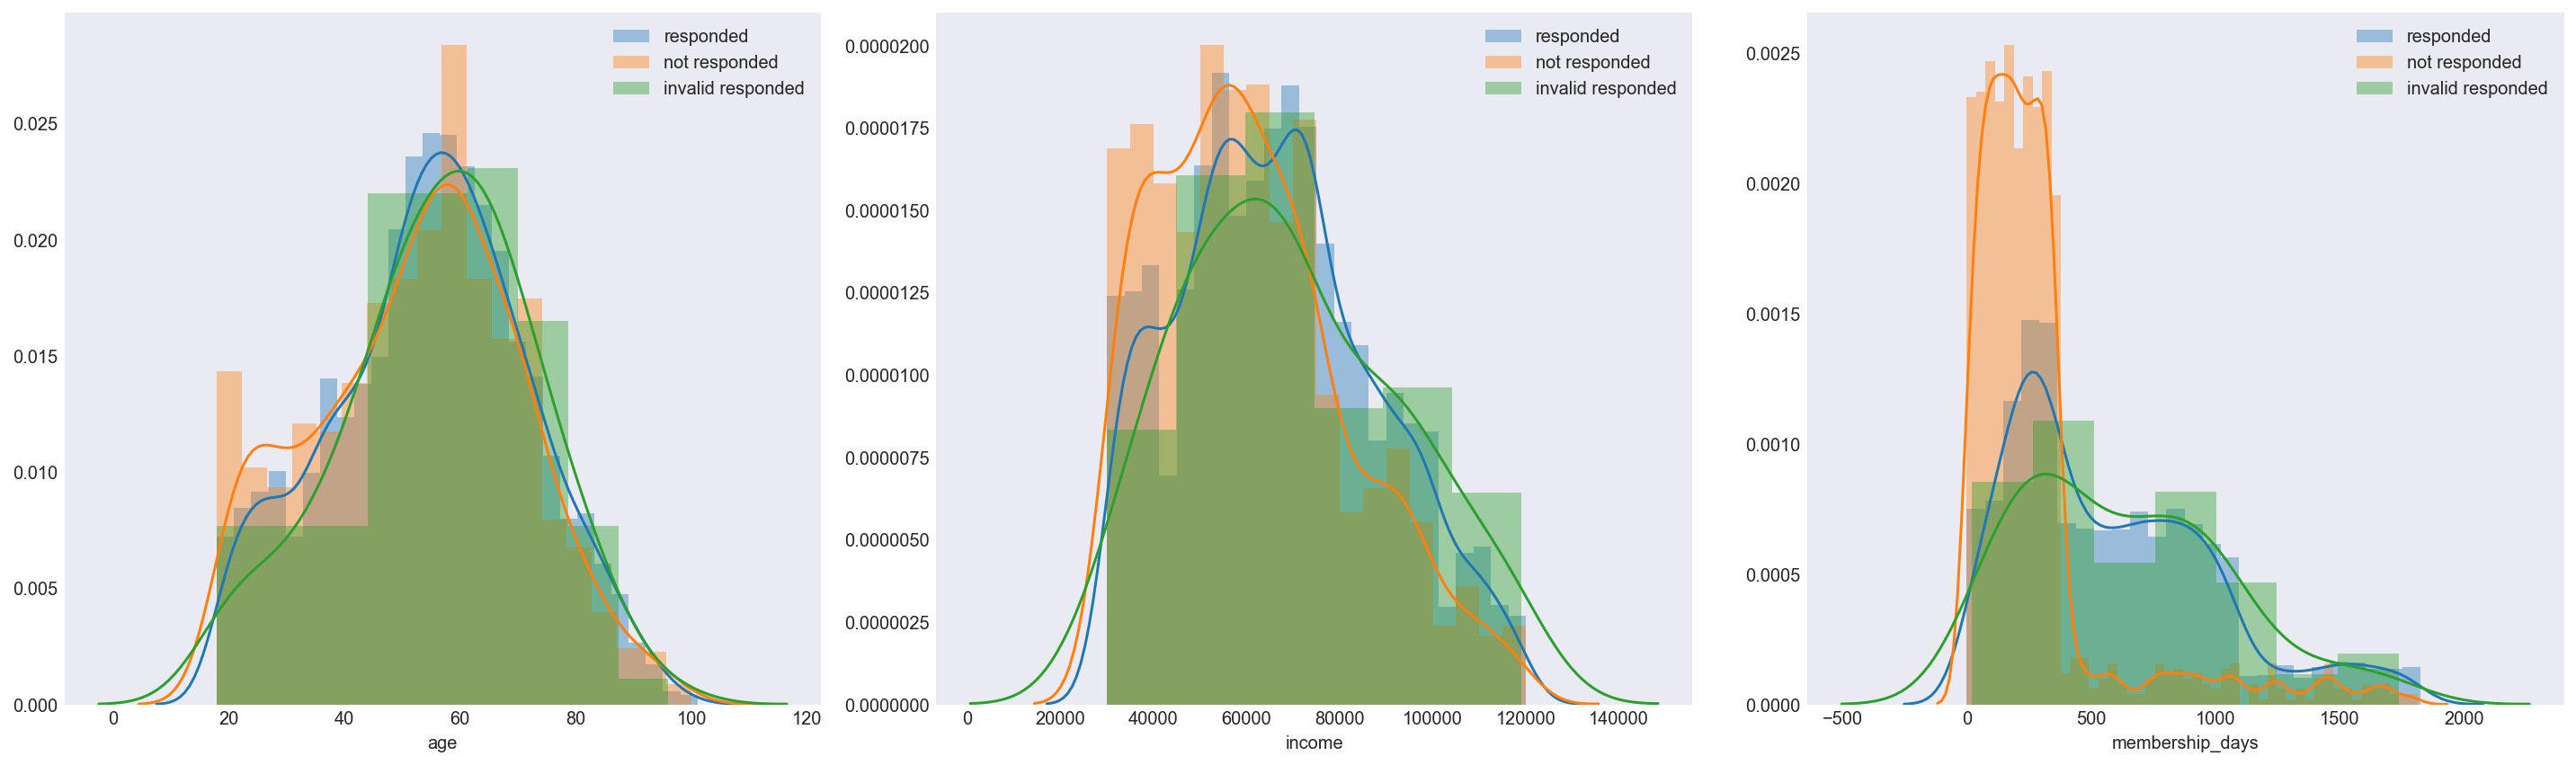

In [25]:
plot_compare_3_groups(create_offer_funnels('discount_7_7_3'))

### Demographic EDA for BOGO offers
- The BOGO offer that people love the most is bogo_5_5_5, with a 58.37% response rate
- The BOGO offer that people love the least is bogo_5_7_5, with a 39.4% response rate

### Insights
- For bogo offers, a longer expiration period actually led to lower response rate
- Although the difference isn't too significant, could be due to randomness in the experiment

In [26]:
bogo_offers

['bogo_5_7_5', 'bogo_10_5_10', 'bogo_5_5_5', 'bogo_10_7_10']

39.4 % customers responded to offers
40.46 % customers did not respond to any offer
20.14 % customers completed offers without viewing offer


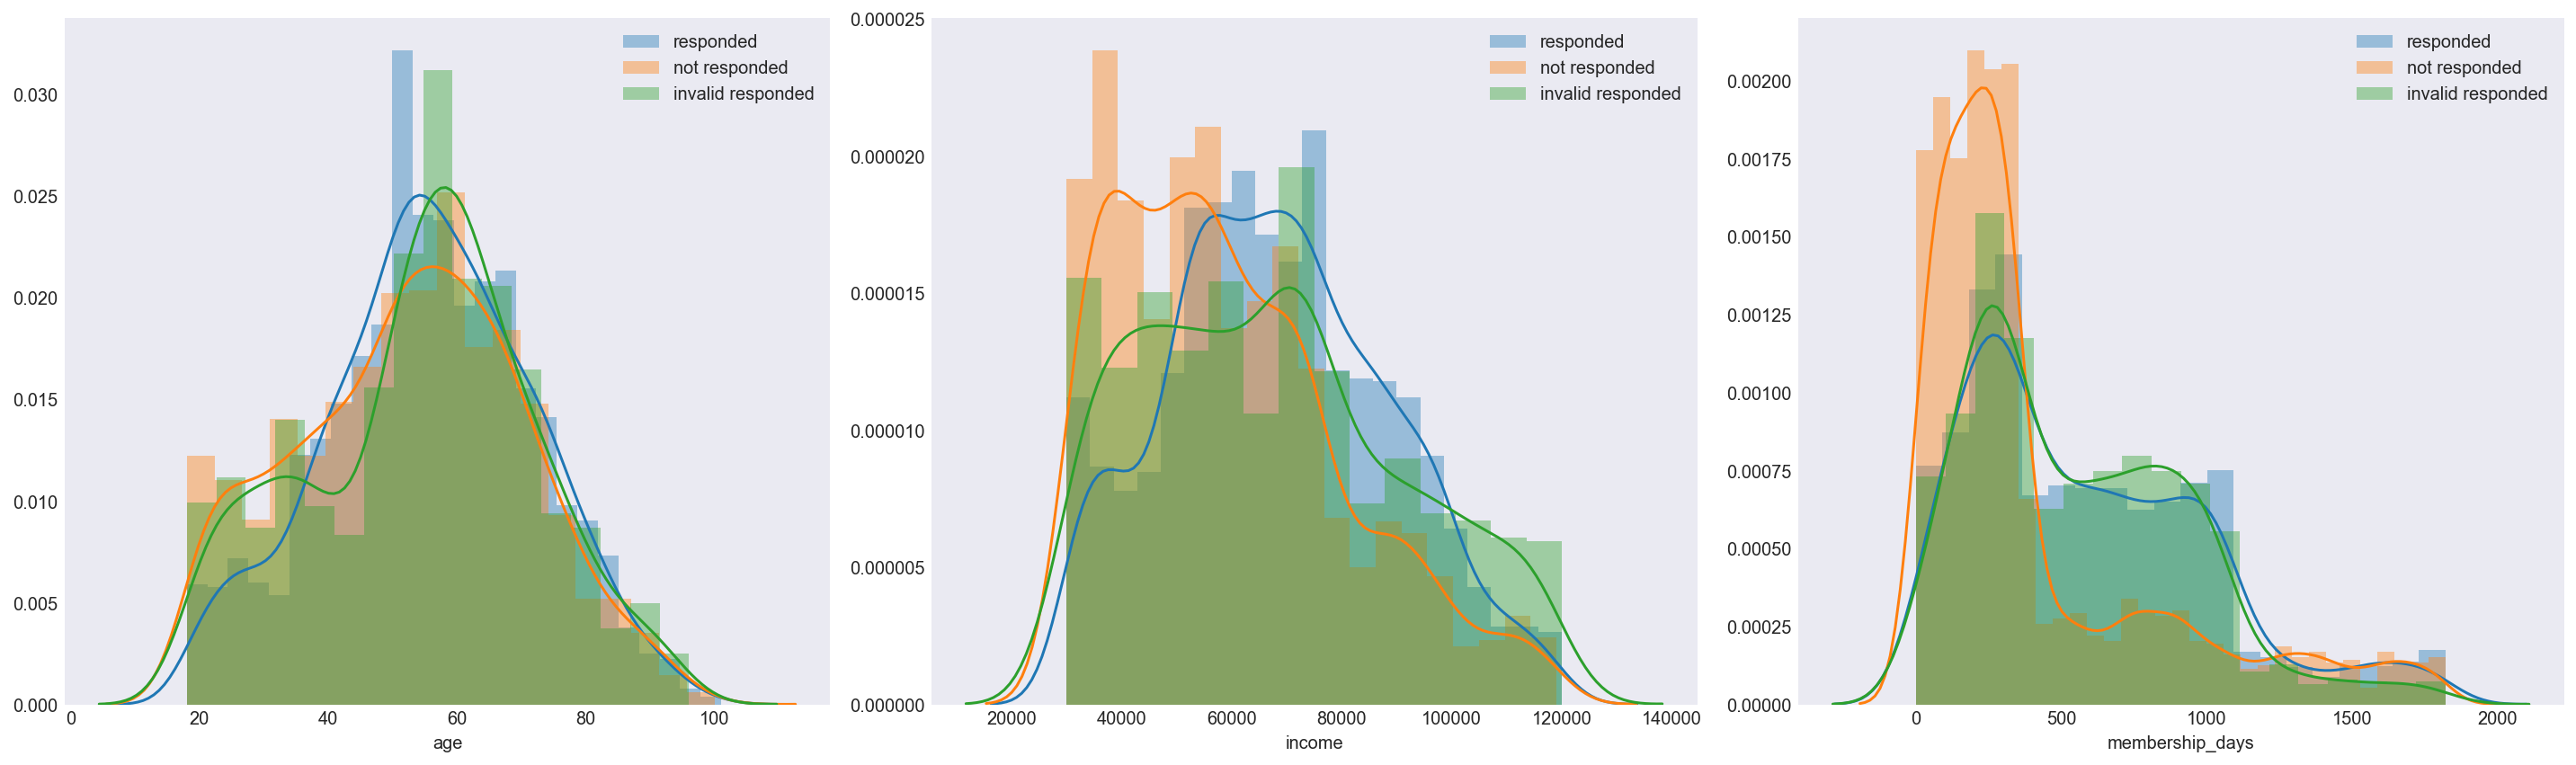

In [27]:
plot_compare_3_groups(create_offer_funnels('bogo_5_7_5'))

44.63 % customers responded to offers
54.42 % customers did not respond to any offer
0.95 % customers completed offers without viewing offer


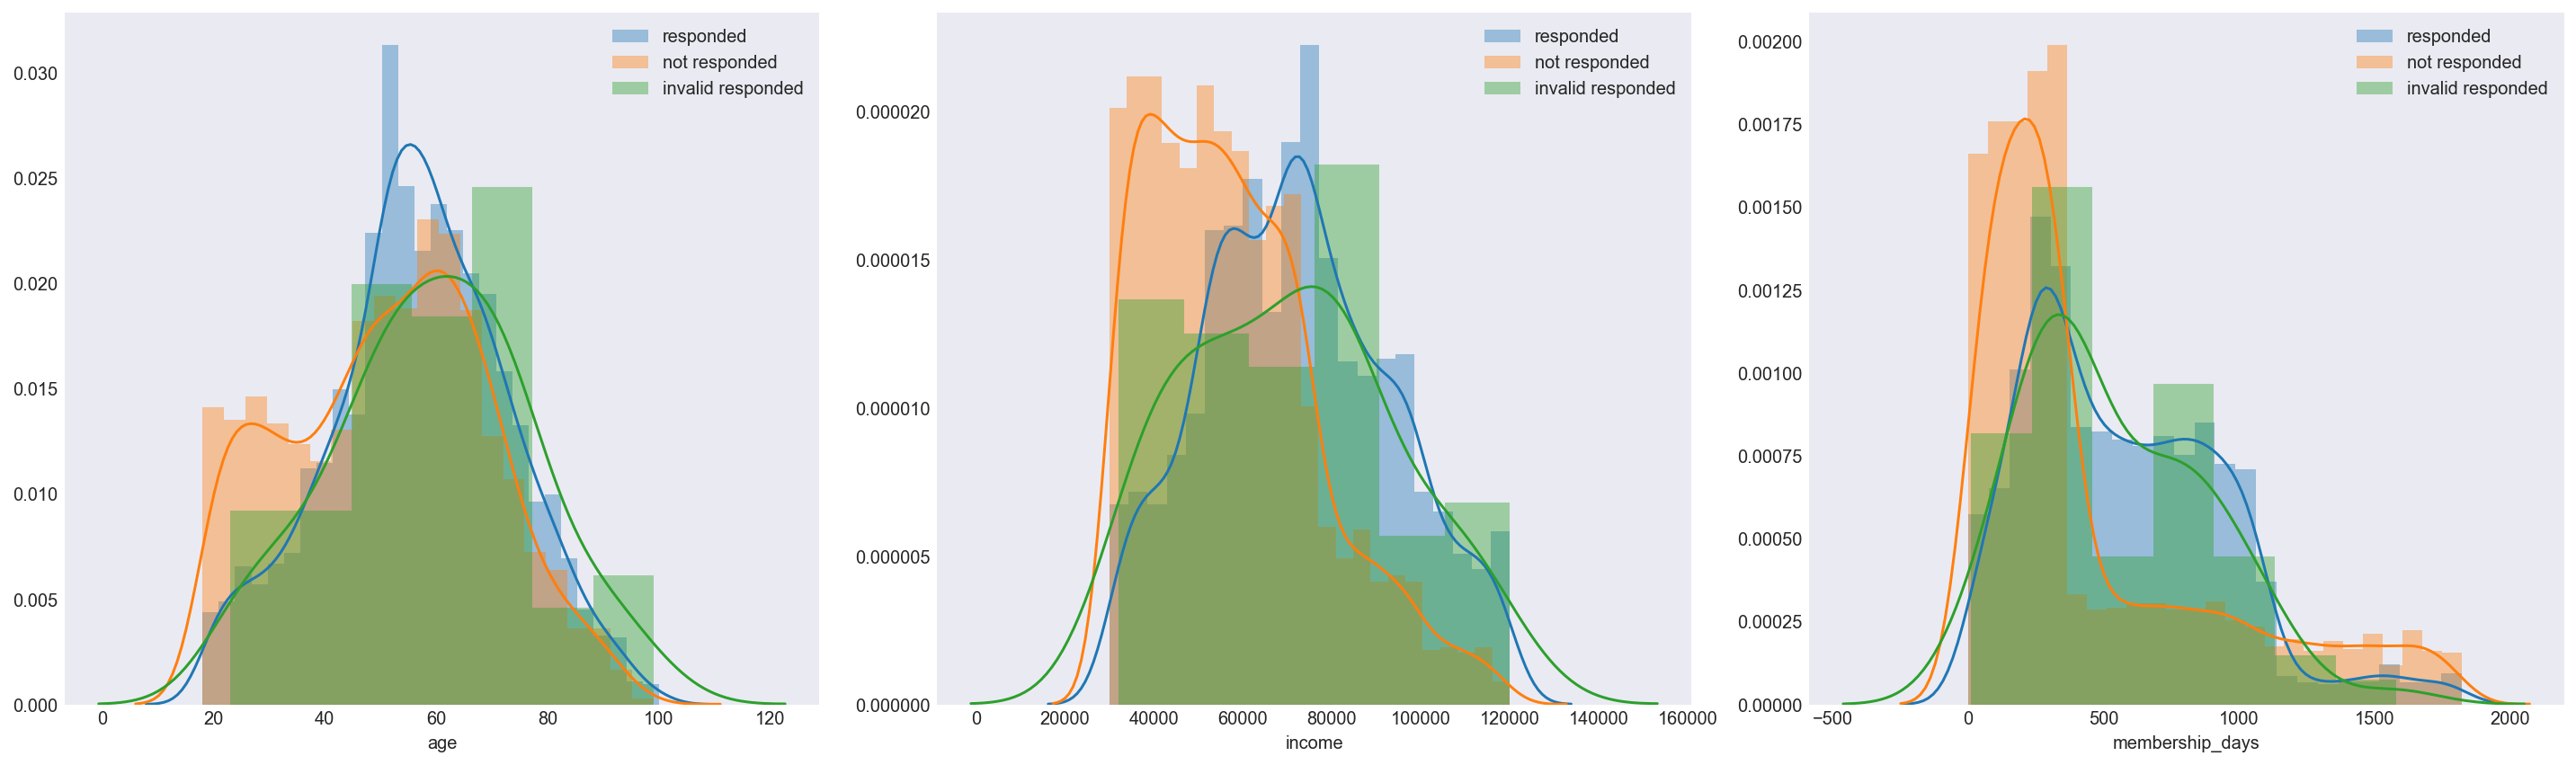

In [28]:
plot_compare_3_groups(create_offer_funnels('bogo_10_5_10'))

58.37 % customers responded to offers
40.26 % customers did not respond to any offer
1.37 % customers completed offers without viewing offer


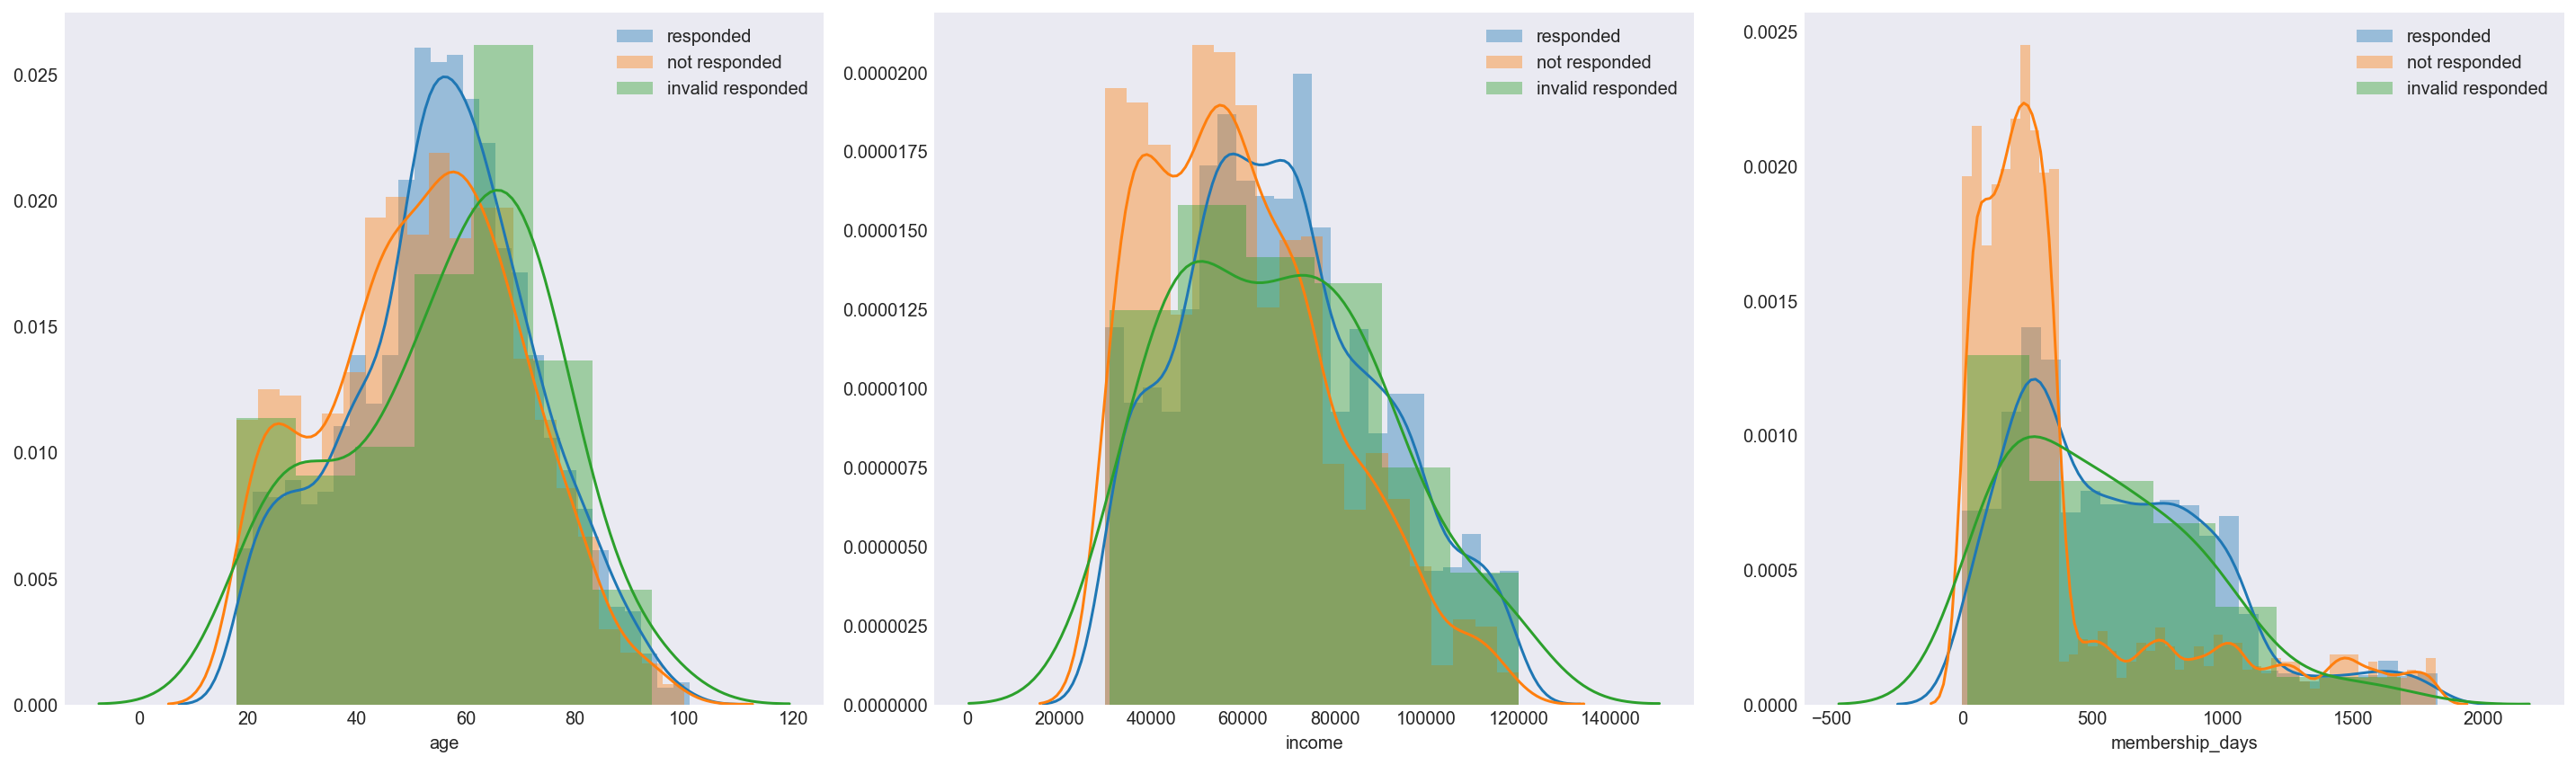

In [29]:
plot_compare_3_groups(create_offer_funnels('bogo_5_5_5'))

44.6 % customers responded to offers
50.16 % customers did not respond to any offer
5.24 % customers completed offers without viewing offer


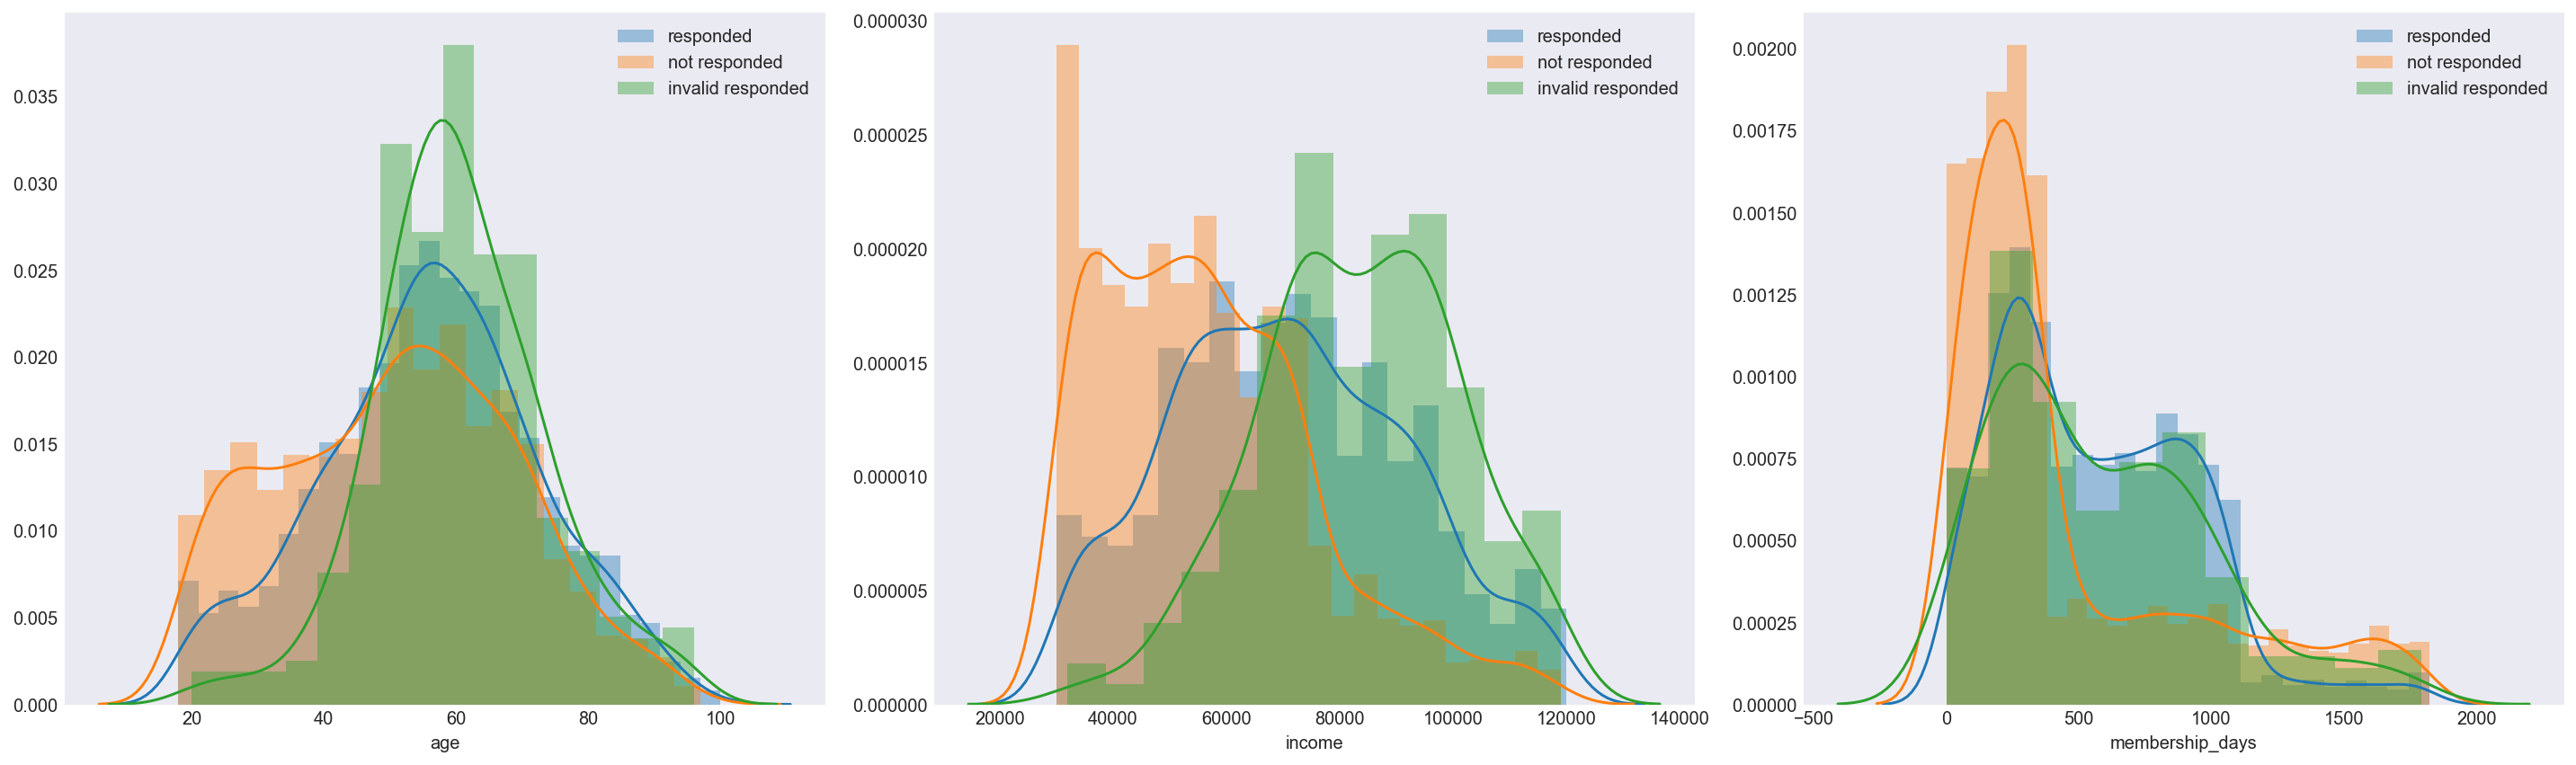

In [30]:
plot_compare_3_groups(create_offer_funnels('bogo_10_7_10'))

### Impute transactions and amount spent per week per customer
The reason why I chose weekly average as the metric is due to the nature of the test. This test is conducted for a month, while certain customers received their first offers from the first day, while some customers received their first offer at the end of the month. 

In [79]:
# left join weekly transactions to customers data
weekly_transactions = (transaction_events.groupby('customer_id').event.count()/4).to_frame().reset_index().rename({'event':'weekly_transactions'},axis=1)
customers = pd.merge(customers, weekly_transactions, how='left', left_on='id', right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.head()

,gender,age,id,income,membership_days,responded,not_responded,invalid_responded,response,weekly_transactions
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,0,1,invalid_responded,0.75
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,0,responded,1.75
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,0,responded,0.75
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,0,responded,0.75
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,responded,1.00


In [80]:
# Merge average weekly amount spent to customers dataset
weekly_amount_spent = (transaction_events.groupby('customer_id').amount_spent.sum()/4).to_frame().reset_index().rename({'amount_spent':'weekly_amount_spent'},axis=1)
customers = pd.merge(customers, weekly_amount_spent, how='left',left_on='id',right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.fillna(0,inplace=True)
customers.head()

,gender,age,id,income,membership_days,responded,not_responded,invalid_responded,response,weekly_transactions,weekly_amount_spent
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,0,1,invalid_responded,0.75,19.2525
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,0,responded,1.75,39.8175
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,0,responded,0.75,14.4325
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,0,responded,0.75,9.1075
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,responded,1.00,3.9050


### responded customers have higher weekly transactions and amount spent than those who didn't respond

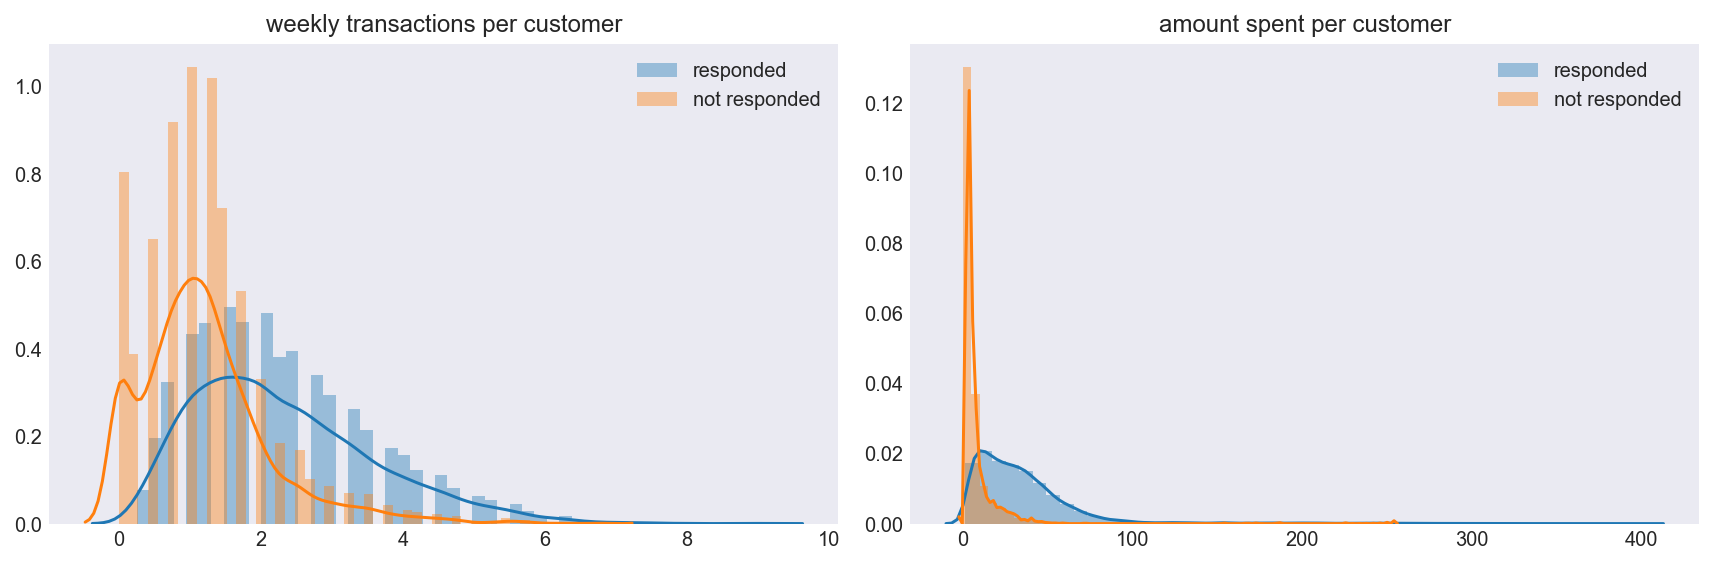

In [81]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(customers[customers.responded == 1].weekly_transactions,label='responded');
sns.distplot(customers[customers.responded == 0].weekly_transactions,label='not responded');
plt.legend(); plt.title('weekly transactions per customer'); plt.xlabel('');
plt.subplot(1,2,2)
sns.distplot(customers[customers.responded == 1].weekly_amount_spent,label='responded');
sns.distplot(customers[customers.responded == 0].weekly_amount_spent,label='not responded');
plt.legend(); plt.title('amount spent per customer'); plt.xlabel('');
plt.tight_layout()

# Build Machine Learning Model to classify customer response to offers

In [82]:
# Examine the ratios of target classes to decide on the classification metrics
print('valid response ratio:')
print(customers.responded.value_counts()/len(customers))

valid response ratio:
1    0.797031
0    0.202969
Name: responded, dtype: float64


In [34]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_days','weekly_transactions','weekly_amount_spent']]

# Convert categorical features into dummy variables
X = pd.get_dummies(X)
X.drop('gender_O',axis=1,inplace=True)
X.head()

,age,income,membership_days,weekly_transactions,weekly_amount_spent,gender_F,gender_M
0,55.0,112000.0,376,0.75,19.2525,1,0
1,75.0,100000.0,443,1.75,39.8175,1,0
2,68.0,70000.0,91,0.75,14.4325,0,1
3,65.0,53000.0,167,0.75,9.1075,0,1
4,58.0,51000.0,257,1.00,3.9050,0,1


## Compare ROC curves for different target variables
- We have 3 potential target variables to predict - responded, discount_responded, bogo_responded
- We already have good understandings of the 8 offers regarding response rates and demographics, we don't need to build a model for each offers as it could be biased due to the fact that not every customer received the same offer
- Depending on Starbuck's business objective, we can choose to predict whether the customer will respond to any offer at all; or predict whether the customer will respond to discount or bogo offers

In [32]:
def compare_roc(target):
    '''
    plot ROC for the given target variable - response/invalid response
    '''
    y = customers[target]
    # Set discount_response as the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title(f'ROC for {target}')

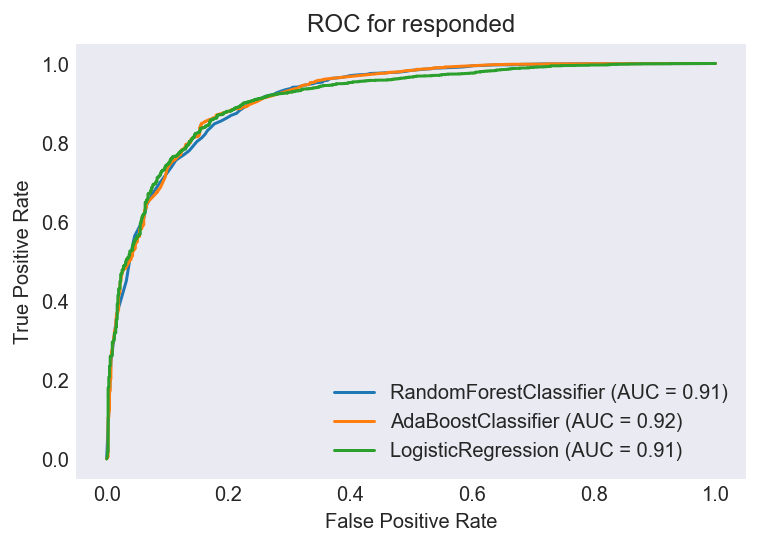

In [33]:
compare_roc('responded')

# Use GridSearchCV to find the best parameters for AdaBoost

In [34]:
# Get available parameters
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [35]:
# Set y as response
y = customers['responded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

model = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'f1 score on the testset: {f1_score(y_test, y_pred)}')
print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
f1 score on the testset: 0.9387090205660761
accuracy on the testset: 0.8984480431848852


# Conclusion
After extensive EDA and data visualizations, I have come to the conclusion that the demographics for the 3 response groups have similar patterns regardless of offer_types:
- not_responded: customers with the lowest age, lowest income, and lowest days of membership
- invalid_responded: customers with the highest age, highest income, and highest days of membership
- responded: customers with age, income and days of membership in the middle, all slightly less than the invalid_responded group

Firstly, I analyzed demographics for 3 response groups from a macro level - all offers, and found out:
- 74.4 % customers responded to at least 1 offer
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed all received offers without viewing them

Secondly, I analyzed demographics for 3 response groups for discount offers VS bogo offers, and found out:
- discount offers seems to have a slightly higher response rate than bogo offers (63% verses 59%)
- The demographics of discount and bogo response groups are quite similar

Thirdly, I analyzed demographics for 3 response groups for all 8 offers, and found out:
For discount offers:
- The discount offer people love the most is discount_10_10_2, with 70.1% response rate
- The discount offer people love the least is discount_20_10_5, with 23.09% response rate
- This may be due to the fact that the favorable offer has a lower barrier (10 dollars) whereas the least favorable offer has a high minimum spend (20 dollars)
- discount_10_7_2 has a 38% response rate whereas discount_10_10_2 has a 70.1% response rate, this may suggest that an 10-day expiration period gets much more responses than a 7-day expiration period
- In conclusion, people respond better to lower minimum spend and longer expiration days

For BOGO offers:
- The BOGO offer that people love the most is bogo_5_5_5, with a 58.37% response rate
- The BOGO offer that people love the least is bogo_5_7_5, with a 39.4% response rate
- It seems to be a different case for bogo offers, such that with the same conditions, a lower expiration period resulted in higher response rate

Lastly, I built an AdaBoost Machine Learning Model to predict customer response with a 0.92 ROC AUC, 0.94 F1 score and 0.90 accuracy. Because this is an open ended project, it was difficult for me to conclude on a business impact from this model, although it is high performing. Starbucks has many reasons to send out offers, such as promoting a new drink, boosting sales, increasing customer retention and loyalty, etc. If Starbucks wants to increase sales, sending out offers will certainly increase revenue, but not neccessarily profits, unless the promotion has an impact on sales after the promotions which will increase long term profit. 

But why do we bother to predict customer response instead of sending out offers to everyone? There are a number of reasons. First of all, not everyone responds positively to offers, some may dislike them, and it would be a better idea not to send them. Secondly, Starbucks wants to know which of the 8 offers can really excite people, so they can target the right customers with the right offers to ensure best response. Lastly, 1.06% of all customers in the dataset completed the offers without viewing them, which means that they would have spent the same amount of money without the offer. By not sending offers to those customers, Starbucks can save promotion costs associated with the offers. (we know that this 1.06% are people with highest income, highest age, and longest memberships)

# Improvements
This one-month experiment has its limitations. For example, not everyone received the same offers, so we don't know if a certain customer would have responded to another offer, should he/she receive it. Also, not everyone received their first offers at the same time. Although most customers received their first offer at the beginning of the experiment, there are 6 phases where Starbucks sent out first offers to customers. This means a few things: firstly, it is not fair to use offer completion rate as a metric, because every customer got a different number of offers throughout the experiment; secondly, weekly_transactions and weekly_amount_spent should be based on the assumption that all customers are in the same state (with offers or without offers), but the discrepancies in the data can make these 2 metrics biased and not reflect the actual purchasing behaviors of customers. 